## Introduction

Sentiment analysis is an important application of natural language processing, as it makes it possible to predict what a person thinks given the text she has written. 

For example, let's say you own a company and you would like to monitor the opinion of your customers on twitter. It's fairly easy to detect the tweets in which your company or products is mentioned, and to find out how many times these tweets are liked or retweeted. 

But tweets and likes do not mean that people like what you're doing! Maybe they're just destroying the reputation of your company online, or they like a funny tweet in which somebody says your products are really bad. 

That's where sentiment analysis is needed: it will tell you whether the tweet is positive or negative for your company, and how you should interpret all these likes and retweets.  

This post is the fourth part of my tutorial series about natural language processing. You will learn how to classify the reviews of the large [yelp dataset](https://www.yelp.com/dataset) as positive or negative with two different deep neural networks.

First, we will try a simple network consisting of an **embedding layer**, a **dense layer**, and a final **sigmoid neuron**. 

Then, we will see how **convolutional layers** can help us improve performance. 

If you don't know the terms used above, you can refer to these tutorials: 

* embedding is explained in [word embedding and simple sentiment analysis](https://thedatafrog.com/word-embedding-sentiment-analysis/);
* dense layers are introduced in [handwritten digit recognition with scikit-learn](https://thedatafrog.com/handwritten-digit-recognition-scikit-learn/);
* the sigmoid neuron is described in details in [the 1-neuron network: logistic regression](https://thedatafrog.com/logistic-regression/);
* convolutional layers are described at length in [tuning a deep convolutional network for image recognition, with keras and tensorflow](https://thedatafrog.com/deep-learning-keras/)

Also, you will need to follow [this tutorial](https://thedatafrog.com/text-preprocessing-machine-learning-yelp/) to access the yelp dataset and preprocess it for machine learning. 

Finally, access to a GPU will save you a lot of time, as we want to train our neural networks on a large number of events here. 

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# get reproducible results
from numpy.random import seed
seed(0xdeadbeef)
from tensorflow import set_random_seed
set_random_seed(0xdeadbeef)

# needed to run on a mac: 
import os 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [22]:
import keras

In [27]:
import h5py
datadir = '/data2/cbernet/maldives/yelp_dataset/'
datafile = datadir+'data.h5'
h5 = h5py.File(datafile)


In [28]:
data = h5['reviews']
data = data[:]

In [29]:
x = data[:,1:]
stars = data[:,0]

In [54]:
len(x[0])

250

In [48]:
y = np.zeros_like(stars)
y[stars>3.5] = 1
print(y, len(y))
print(stars, len(stars))

[1 0 1 ... 0 0 0] 6685900
[5 3 5 ... 1 1 3] 6685900


In [80]:
n_test = 20000
n_train = 7000000
x_test = x[:n_test]
y_test = y[:n_test]
x_train = x[n_test:n_train]
y_train = y[n_test:n_train]

In [50]:
from vocabulary import Vocabulary
vocab = Vocabulary(dbfname=datadir+'/index')

In [56]:
len(vocab.words)

20002

In [51]:
rev = x_test[0] # 1st test review
rev = rev[rev!=0] # remove padding
' '.join(vocab.decode(rev))

'helped out when locked out apartment he quick got at price lowest comparison all other area definately recommend top master situations requiring locksmith they get job done quickly effectively'

(array([3323.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6677.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

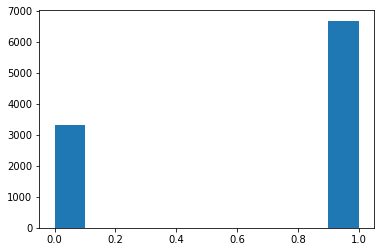

In [53]:
plt.hist(y_test[:])

In [122]:
model = keras.Sequential()

# the first layer is the embedding layer. 
# we indicate the number of possible words, 
# the dimension of the embedding space, 
# and the maximum size of the text. 
model.add(keras.layers.Embedding(len(vocab.words), 64, input_length=250))

# the output of the embedding is multidimensional, 
# with shape (256, 2)
# for each word, we obtain two values, 
# the x and y coordinates
# we flatten this output to be able to 
# use it in a dense layer
model.add(keras.layers.Flatten())

# dropout regularization
model.add(keras.layers.Dropout(rate=0.4))

# small dense layer. It's role is to analyze 
# the distribution of points from embedding
model.add(keras.layers.Dense(100))

# final neuron, with sigmoid activation 
# for binary classification
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 250, 64)           1280128   
_________________________________________________________________
flatten_12 (Flatten)         (None, 16000)             0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16000)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 100)               1600100   
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 101       
Total params: 2,880,329
Trainable params: 2,880,329
Non-trainable params: 0
_________________________________________________________________


In [123]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train,
                    y_train,
                    epochs=2,
                    batch_size=1000,
                    validation_data=(x_test, y_test),
                    verbose=1)

Train on 6665900 samples, validate on 20000 samples
Epoch 1/2
6665900/6665900 [==============================] - 115s 17us/step - loss: 0.2377 - acc: 0.9056 - val_loss: 0.2204 - val_acc: 0.9126
Epoch 2/2
6665900/6665900 [==============================] - 115s 17us/step - loss: 0.2270 - acc: 0.9107 - val_loss: 0.2200 - val_acc: 0.9139


In [124]:
x_sample = x_test[:100]
y_sample = y_test[:100]
preds = model.predict_classes(x_sample)
preds = np.array(preds).flatten()
preds

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1], dtype=int32)

In [125]:
y_sample

array([1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1], dtype=int16)

In [126]:
idx = preds!=y_sample
miscl = x_sample[idx]
miscl_pred = preds[idx]
miscl_true = y_sample[idx]

In [127]:
for pred, true, rev in zip(miscl_pred, miscl_true, miscl):
    rev = rev[rev!=0] # remove padding
    print(pred, true)
    print(' '.join(vocab.decode(rev)))
    print('\n')

1 0
on wet snowy sunday afternoon made trek out famous fairmount bagels since st. close decided pick up some from there as well compare each other as well as bagels all name research people ! fairmount vs. st. bagels from both locations were fresh from oven still warm when they were handed us ca n't say preferred one over other eventually bagels from both locations were mixed up could n't pick out which ones came from where they were also both great with cream cheese & smoked salmon montreal vs. ny : both respectable their own way ny counterparts & thicker can taken more seriously as meal montreal bagels thinner with more crust crumb ratio best eaten as snack love snacks overall enjoy all bagels refuse play this silly game favorites


1 0
this hotel mixed bag 5 stars chandelier 2 stars layout 4 stars location on strip 4 stars rooms 2 stars cleanliness chandelier all on its own everyone has take at least one picture front gorgeous hotel overall classy chic very modern personally n't lik

In [135]:
model = keras.Sequential()

# the first layer is the embedding layer. 
# we indicate the number of possible words, 
# the dimension of the embedding space, 
# and the maximum size of the text. 
model.add(keras.layers.Embedding(len(vocab.words), 64, input_length=250))

model.add(keras.layers.Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))

# the output of the embedding is multidimensional, 
# with shape (256, 2)
# for each word, we obtain two values, 
# the x and y coordinates
# we flatten this output to be able to 
# use it in a dense layer
model.add(keras.layers.Flatten())

# dropout regularization
model.add(keras.layers.Dropout(rate=0.4))

# small dense layer. It's role is to analyze 
# the distribution of points from embedding
model.add(keras.layers.Dense(100, activation='relu'))

# final neuron, with sigmoid activation 
# for binary classification
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 250, 64)           1280128   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 250, 16)           3088      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 125, 16)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 125, 32)           1568      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 62, 32)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 62, 64)            6208      
_________________________________________________________________
flatten_17 (Flatten)         (None, 3968)              0         
__________

In [136]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train,
                    y_train,
                    epochs=4,
                    batch_size=1000,
                    validation_data=(x_test, y_test),
                    verbose=1)

Train on 6665900 samples, validate on 20000 samples
Epoch 1/4
6665900/6665900 [==============================] - 138s 21us/step - loss: 0.1827 - acc: 0.9271 - val_loss: 0.1641 - val_acc: 0.9348
Epoch 2/4
6665900/6665900 [==============================] - 137s 21us/step - loss: 0.1590 - acc: 0.9370 - val_loss: 0.1592 - val_acc: 0.9358
Epoch 3/4
6665900/6665900 [==============================] - 137s 21us/step - loss: 0.1500 - acc: 0.9407 - val_loss: 0.1604 - val_acc: 0.9374
Epoch 4/4
6665900/6665900 [==============================] - 137s 21us/step - loss: 0.1433 - acc: 0.9436 - val_loss: 0.1601 - val_acc: 0.9381


In [137]:
model = keras.Sequential()

# the first layer is the embedding layer. 
# we indicate the number of possible words, 
# the dimension of the embedding space, 
# and the maximum size of the text. 
model.add(keras.layers.Embedding(len(vocab.words), 64, input_length=250))

model.add(keras.layers.Conv1D(filters=16, kernel_size=5, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=2))

# the output of the embedding is multidimensional, 
# with shape (256, 2)
# for each word, we obtain two values, 
# the x and y coordinates
# we flatten this output to be able to 
# use it in a dense layer
model.add(keras.layers.Flatten())

# dropout regularization
model.add(keras.layers.Dropout(rate=0.4))

# small dense layer. It's role is to analyze 
# the distribution of points from embedding
model.add(keras.layers.Dense(100, activation='relu'))

# final neuron, with sigmoid activation 
# for binary classification
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 250, 64)           1280128   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 250, 16)           5136      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 125, 16)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 125, 32)           2080      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 62, 32)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 62, 64)            6208      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 31, 64)            0         
__________

In [138]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train,
                    y_train,
                    epochs=4,
                    batch_size=1000,
                    validation_data=(x_test, y_test),
                    verbose=1)

Train on 6665900 samples, validate on 20000 samples
Epoch 1/4
6665900/6665900 [==============================] - 146s 22us/step - loss: 0.1818 - acc: 0.9273 - val_loss: 0.1615 - val_acc: 0.9356
Epoch 2/4
6665900/6665900 [==============================] - 146s 22us/step - loss: 0.1575 - acc: 0.9377 - val_loss: 0.1580 - val_acc: 0.9389
Epoch 3/4
6665900/6665900 [==============================] - 146s 22us/step - loss: 0.1476 - acc: 0.9419 - val_loss: 0.1580 - val_acc: 0.9372
Epoch 4/4
6665900/6665900 [==============================] - 146s 22us/step - loss: 0.1393 - acc: 0.9454 - val_loss: 0.1594 - val_acc: 0.9376


In [139]:
model = keras.Sequential()

# the first layer is the embedding layer. 
# we indicate the number of possible words, 
# the dimension of the embedding space, 
# and the maximum size of the text. 
model.add(keras.layers.Embedding(len(vocab.words), 64, input_length=250))

model.add(keras.layers.Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))

# the output of the embedding is multidimensional, 
# with shape (256, 2)
# for each word, we obtain two values, 
# the x and y coordinates
# we flatten this output to be able to 
# use it in a dense layer
model.add(keras.layers.Flatten())

# dropout regularization
model.add(keras.layers.Dropout(rate=0.5))

# small dense layer. It's role is to analyze 
# the distribution of points from embedding
model.add(keras.layers.Dense(100, activation='relu'))

# final neuron, with sigmoid activation 
# for binary classification
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train,
                    y_train,
                    epochs=4,
                    batch_size=1000,
                    validation_data=(x_test, y_test),
                    verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 250, 64)           1280128   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 250, 16)           3088      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 125, 16)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 125, 32)           1568      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 62, 32)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 62, 64)            6208      
_________________________________________________________________
flatten_19 (Flatten)         (None, 3968)              0         
__________